In [1]:
import sys
sys.path
sys.path.append('/Users/mulingsi/Desktop/MSE346/RL-book/')

In [172]:
from dataclasses import dataclass
from typing import Optional, Mapping, Dict, Sequence, Tuple, Callable
import numpy as np
import itertools
from rl.distribution import Categorical, Constant, Choose
from rl.markov_process import MarkovProcess, Transition, FiniteMarkovProcess
from scipy.stats import poisson
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func

import matplotlib.pyplot as plt

**Note:** Solved for Q1, Q2, Q4 first as they all belong to the Snakes and Ladders problem. Q3 and Q5 follows.

# Q1: Snake and Ladders - setup

![](SL-graph.jpg)

- State Space: $\mathcal{S}$ = {0, 1, ..., 100}, $\mathcal{T} $={100}, 
- Transition Probabilities: There are three kinds of states - regular, snake, and ladder states. The snake states send you to a lower state and the ladder sends you higher state. There's also the bounce back rule that if your roll goes to above 100, you'll be send back for the additional rolls that goes above 100. Details see Q2.

# Q2: Snake and ladder - transition map

In [3]:
@dataclass(frozen=True)
class PositionState:
    position: int


class SnakeLadder(FiniteMarkovProcess[PositionState]):

    def __init__(
        self,
       
        dice_size: int,
        board_size: int,
        snake_ladders: Dict[int, int],):
        self.dice_size = dice_size
        self.board_size =board_size
        self.snake_ladders =snake_ladders
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[PositionState]:
        d: Dict[PositionState, Optional[Categorical[PositionState]]] = {
            PositionState(self.board_size) : None
        }
        for pos in range(self.board_size):
            state = PositionState(pos)
            state_probs_map: Mapping[PositionState, float] = {}
            
            # roll dice 
            for dice_roll in range(1,self.dice_size+1):
                # roll back towards the end of the game
                if dice_roll+pos >100:
                    tmp_j = 100-(dice_roll+pos-100)
                    # check if rolls back to a snake/ladder state
                    if tmp_j in self.snake_ladders.keys():
                        j = self.snake_ladders[tmp_j]
                    else:
                        j = tmp_j
                elif dice_roll+pos in self.snake_ladders.keys():
                    j = self.snake_ladders[dice_roll+pos]
                else:
                    j = dice_roll+pos
                
                state_probs_map[PositionState(j)] = 1/self.dice_size
            d[state] = Categorical(state_probs_map)
        return d
    

In [4]:
snakes_map = {38:1,31:6, 49:8,65:14,53:17,70:34,76:37,94:42,88:50,82:63,98:54
              
}
ladders_map = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90, 69:92,77:83

}

snakes_and_ladders_map = {**snakes_map, **ladders_map}

In [5]:
if __name__ == '__main__':

    sl_mp = SnakeLadder(
        board_size=100,
        dice_size=6,
       snake_ladders =snakes_and_ladders_map 
    )
    print("Transition Map")
    print("--------------")
    print(sl_mp)

Transition Map
--------------
PositionState(position=100) is a Terminal State
From State PositionState(position=0):
  To State PositionState(position=1) with Probability 0.167
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
From State PositionState(position=1):
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
  To State PositionState(position=48) with Probability 0.167
From State PositionState(position=2):
  To State PositionState(position=39) with Probability 0.167
  To State PositionState

In [44]:
def mp_traces_count(
    input_mp: SnakeLadder,
    num_traces: int
)->np.ndarray:
    return np.hstack([
        len([s for s in input_mp.simulate(Constant(PositionState(0)))]) for _ in range(num_traces)])


In [86]:
def mp_traces(
    input_mp: SnakeLadder,
    num_traces: int
)->np.ndarray:
    return [
        [s.position for s in input_mp.simulate(Constant(PositionState(0)))] for _ in range(num_traces)]


In [89]:
#### test is the trace simulations are functioning as expected:
mp_traces_count(sl_mp, 3)

array([ 20, 131,  21])

In [90]:
len(mp_traces(sl_mp, 3))

3

In [93]:
#### test check the simulated paths:
t = mp_traces(sl_mp, 3)
c=0
for i in t:
    print('trace: ' + str(c+1))
    print(i)
    c=c+1

trace: 1
[0, 4, 9, 13, 15, 17, 23, 57, 85, 87, 90, 93, 42, 47, 17, 23, 24, 27, 33, 34, 37, 41, 43, 46, 47, 50, 54, 58, 62, 68, 71, 83, 50, 17, 18, 21, 22, 35, 37, 1, 48, 51, 52, 54, 57, 62, 90, 42, 43, 44, 48, 54, 55, 57, 62, 66, 72, 74, 79, 63, 14, 17, 18, 24, 27, 33, 34, 1, 2, 48, 52, 57, 63, 64, 66, 72, 74, 80, 85, 90, 96, 97, 54, 58, 59, 85, 50, 17, 19, 57, 63, 92, 96, 97, 54, 55, 57, 62, 90, 95, 96, 54, 56, 59, 61, 90, 95, 96, 54, 59, 85, 87, 92, 93, 96, 54, 58, 85, 90, 42, 47, 17, 21, 57, 58, 85, 90, 93, 99, 54, 56, 85, 89, 92, 54, 58, 85, 50, 51, 52, 57, 63, 66, 92, 97, 97, 54, 56, 59, 64, 34, 40, 44, 46, 52, 55, 85, 91, 92, 42, 43, 47, 17, 41, 46, 51, 52, 57, 59, 64, 66, 90, 96, 54, 55, 59, 61, 14, 16, 19, 21, 22, 35, 40, 44, 48, 8, 9, 51, 57, 63, 68, 34, 36, 40, 41, 43, 74, 80, 83, 85, 91, 95, 99, 97, 100]
trace: 2
[0, 1, 48, 51, 54, 56, 58, 62, 68, 73, 78, 83, 89, 92, 97, 97, 100]
trace: 3
[0, 5, 9, 14, 19, 57, 61, 90, 96, 100]


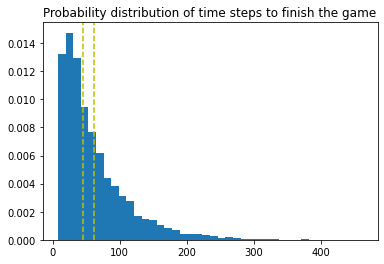

In [103]:
sim_count = mp_traces_count(sl_mp, 10000)
plt.hist(sim_count , density=True, bins=40)
plt.title("Probability distribution of time steps to finish the game")
plt.axvline(np.mean(sim_count ), c='y',linestyle='--')
plt.axvline(np.median(sim_count ), c='y',linestyle='--')
plt.show()

In [104]:
print(np.mean(sim_count ))
print(np.median(sim_count ))

61.3682
46.0


# Q4: MRP

To model snakes and ladders as an MRP, we can set the "Reward" of every tile to be 1 and set $\gamma =1$. The value function will then represent how many more rolls are expected at each tile. The expected total number of dice rolls to fiinish the game is the value function at the starting position.

In [105]:
from rl.markov_process import FiniteMarkovRewardProcess

In [106]:
@dataclass(frozen=True)
class PositionState:
    position: int
from rl.markov_process import RewardTransition

In [107]:
class SnakeLadderMRP(FiniteMarkovRewardProcess[PositionState]):

    def __init__(
        self,
       
        dice_size: int,
        board_size: int,
        snake_ladders: Dict[int, int],):
        self.dice_size = dice_size
        self.board_size =board_size
        self.snake_ladders =snake_ladders
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[PositionState]:
        d: Dict[PositionState, Optional[Categorical[Tuple[InventoryState, float]]]] = {
            PositionState(self.board_size) : None
        }
        for pos in range(self.board_size):
            reward = 1 
            state = PositionState(pos)
            state_probs_map: Mapping[Tuple[PositionState, float],int] = {}
            
            # roll dice 
            for dice_roll in range(1,self.dice_size+1):
                # roll back towards the end of the game
                if dice_roll+pos >100:
                    tmp_j = 100-(dice_roll+pos-100)
                    # check if rolls back to a snake/ladder state
                    if tmp_j in self.snake_ladders.keys():
                        j = self.snake_ladders[tmp_j]
                    else:
                        j = tmp_j
                elif dice_roll+pos in self.snake_ladders.keys():
                    j = self.snake_ladders[dice_roll+pos]
                else:
                    j = dice_roll+pos
                
                state_probs_map[PositionState(j), reward] = 1/self.dice_size
            d[state] = Categorical(state_probs_map)
        return d

In [108]:
if __name__ == '__main__':

    sl_mrp = SnakeLadderMRP(
        board_size=100,
        dice_size=6,
       snake_ladders =snakes_and_ladders_map 
    )

    from rl.markov_process import FiniteMarkovProcess
    print("Transition Map")
    print("--------------")
    print(FiniteMarkovProcess(sl_mrp.transition_map))

    print("Transition Reward Map")
    print("---------------------")
    print(sl_mrp)

Transition Map
--------------
PositionState(position=100) is a Terminal State
From State PositionState(position=0):
  To State PositionState(position=1) with Probability 0.167
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
From State PositionState(position=1):
  To State PositionState(position=2) with Probability 0.167
  To State PositionState(position=39) with Probability 0.167
  To State PositionState(position=4) with Probability 0.167
  To State PositionState(position=5) with Probability 0.167
  To State PositionState(position=6) with Probability 0.167
  To State PositionState(position=48) with Probability 0.167
From State PositionState(position=2):
  To State PositionState(position=39) with Probability 0.167
  To State PositionState

In [114]:
# print("Reward Function")
# print("---------------")
# sl_mrp.display_reward_function()
# print()

In [112]:
# print("Value Function")
# print("--------------")
# sl_mrp.display_value_function(gamma=1)
# print()

In [113]:
expected_return = round(sl_mrp.get_value_function_vec(gamma=1)[0], 5)
print("Expected number of dice rolls to finish the game: {}".format(expected_return))

Expected number of dice rolls to finish the game: 59.96233


# Question 3: Frog Puzzle

Puzzle: A frog, 10 lily pads/steps to cross the river, not going backwards, equally likely to arrive at any next lilypads. What's the expected number of jumps?

In [134]:
@dataclass(frozen=True)
class PositionState:
    position: int

class FrogPuzzle(FiniteMarkovRewardProcess[PositionState]):

    def __init__(
        self,
        pond_size: int):
        self.pond_size = pond_size
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> Transition[PositionState]:
        d: Dict[PositionState, Optional[Categorical[Tuple[PositionState, float]]]] = {
            PositionState(self.pond_size) : None
        }
        for pos in range(self.pond_size):
            state = PositionState(pos)
            state_probs_map: Mapping[Tuple(PositionState,float), float] = {}
            for j in range(self.pond_size - pos):
                state_probs_map[PositionState(self.pond_size-j), 1] = 1/(self.pond_size - pos)
            d[state] = Categorical(state_probs_map)
        return d
    

In [141]:
# TEST the MRP to check transition map
if __name__ == '__main__':

    frog_mrp = FrogPuzzle(
        pond_size=10,
    )
    print("Reward transition Map")
    print("--------------")
    print(frog_mrp)

Reward transition Map
--------------
PositionState(position=10) is a Terminal State
From State PositionState(position=0):
  To [State PositionState(position=10) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=9) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=8) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=7) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=6) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=5) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=4) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=3) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=2) and Reward 1.000] with Probability 0.100
  To [State PositionState(position=1) and Reward 1.000] with Probability 0.100
From State PositionState(position=1):
  To [State PositionState(position=10) and Reward

In [139]:
round(frog_mrp.get_value_function_vec(gamma=1)[0],3)

2.929

The expected number of jumps when there're 10 steps towards the other side is 2.93. Generalizing the problem to expected number of jumps when there're X # steps to the other side by changing the input parameter to the MRP, we get:

In [164]:
import pandas as pd
# TEST the MRP to check transition map
exp_jump = pd.DataFrame(index =range(1, 100), columns=['expected'], 
                         data= [round(FrogPuzzle(pond_size=size).get_value_function_vec(gamma=1)[0],3) for size in range(1, 100)])
            

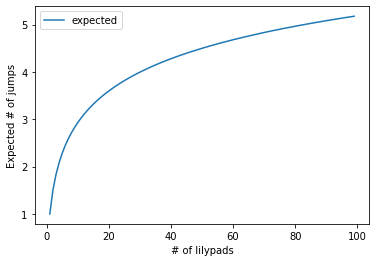

In [168]:
exp_jump .plot()
plt.xlabel('# of lilypads')
plt.ylabel('Expected # of jumps');

# Question 5: Stock Price Example

In [170]:
from rl.markov_process import MarkovRewardProcess

In [194]:
@dataclass(frozen=True)
class StateMP1:
    price: int

@dataclass
class StockPriceMRP1(MarkovRewardProcess[StateMP1]):

    def __init__(self,
        alpha1: float,  #
        level_param: int, 
        reward_function: Callable[[float], float]): 
        self.level_param = level_param
        self.alpha1 = alpha1
        self.reward_function =reward_function
        
    def up_prob(self, state: StateMP1) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)

    def transition_reward(self, state: StateMP1) -> Categorical[StateMP1]:
        up_p = self.up_prob(state)
        
        return Categorical({
            (StateMP1(state.price + 1), self.reward_function(state.price)): up_p,
            (StateMP1(state.price - 1), -1*self.reward_function(state.price)): 1 - up_p
        })

In [195]:
def reward_func(price: float) -> float:
    return price * 0.1

In [196]:
stock_mrp = StockPriceMRP1(alpha1=0.25, level_param=100, reward_function = reward_func)

In [197]:
stock_mrp.transition_reward(StateMP1(105))

{(StateMP1(price=106), 10.5): 0.22270013882530884, (StateMP1(price=104), -10.5): 0.7772998611746912}

In [ ]:
stock_mrp.level_param

In [200]:
## Question: how to incorporate gamma in to MRP?